<a href="https://colab.research.google.com/github/JMFerret/colab/blob/main/2_stocks_simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simulating correlated price stocks in a multi-asset basket
This notebook demonstrates how to simulate price paths in a basket containing >2 correlated assets. To achieve this, it applies [Cholesky decomposition](https://en.wikipedia.org/wiki/Cholesky_decomposition)  on the correlation matrix and generates an array of correlated random numbers. The notebook only serves a narrow demonstration purpose and as such lacks certain user flexiblities.

## Import libraries

In [23]:
#Import libraries
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt, exp
import pandas as pd

## Set coefficient matrix
Observe that the number of stocks and the coefficient matrix $\Sigma$ are treated as constants. When adjusting manually, carefully check that the matrix dimensions align with the number of stocks and that the correlation matrix is semi-definite positive (requirement for Cholesky decomposition).

For this example, volatilies and correlation coefficients for the [Big Tech companies](https://en.wikipedia.org/wiki/Big_Tech)  over 2020 were calculated.

In [35]:
# Manually input number of stocks
NUMBER_OF_STOCKS = 2

STOCK_TICKERS = ["AAPL", "AMZN"]

VOLATILITY_ARRAY =[0.50, 0.50]

correl = 0.9

COEF_MATRIX = np.array([
    [1.0, correl],
    [correl, 1.0],
])

stock_data = {}
stock_data['AAPL'] = {'Vol': 0.4, 'Weight': 0.5}
stock_data['AMZN'] = {'Vol': 0.4, 'Weight': 0.5}


## Perform Cholesky decomposition
This cell performs the Cholesky decomposition on the coefficient matrix $\Sigma$, returning a matrix $R$ that satisfies $\Sigma=R R^*$ and $R^*$ being the conjugate transpose of $R$. Note that the other computations are only for validation purposes.

In [25]:
# Perform Cholesky decomposition on coefficient matrix
R = np.linalg.cholesky(COEF_MATRIX)

# Compute transpose conjugate (only for validation)
RT = R.T.conj()

# Reconstruct coefficient matrix from factorization (only for validation)
print(np.dot(R, RT))

[[1.  0.9]
 [0.9 1. ]]


## Initialize simulation properties
For simplicitly, all stocks have the same initial price $S_{n,0}$ and the same volatility $v_n$.

In [26]:
T = 252                                                  # Number of simulated days
stock_price_array = np.full((NUMBER_OF_STOCKS,T), 100.0) # Stock price, first value is simulation input 
volatility_array = VOLATILITY_ARRAY                      # Volatility (annual, 0.01=1%)
r = 0.001                                                # Risk-free rate (annual, 0.01=1%)
dt = 1.0 / T                                             # Time increment (annualized)

## Run simulation
For each time step, the cell generates a number of standard normal numbers (randomly drawn) and multiplies this with the $R$ matrix obtained from the Cholesky decomposition, yielding an epsilon array with correlated values. Mathematically, this procedure is denoted by $[\epsilon_n]_{\forall n \in \mathcal{N}} =R[x_n]_{\forall n \in \mathcal{N}}$, with $\mathcal{N}$ being the set of assets. The epsilons $\epsilon_n$ are used as inputs for the boilerplate return formula as derived from the Black-Scholes model: $S_t=S_{t-1} * e^{\left(r_f - \frac{\sigma ^2}{2}\right)}  dt + \sigma  \sqrt{dt}  \epsilon_n$

In [27]:
for t in range(1, T):
    # Generate array of random standard normal draws
    random_array = np.random.standard_normal(NUMBER_OF_STOCKS)
    
    # Multiply R (from factorization) with random_array to obtain correlated epsilons
    epsilon_array = np.inner(random_array,R)

    # Sample price path per stock
    for n in range(NUMBER_OF_STOCKS):
        dt = 1 / T 
        S = stock_price_array[n,t-1]
        v = volatility_array[n]
        epsilon = epsilon_array[n]
        
        # Generate new stock price
        stock_price_array[n,t] = S * exp((r - 0.5 * v**2) * dt + v * sqrt(dt) * epsilon)

## Plot simulated paths
With the default settings, the price paths should be highly correlated.

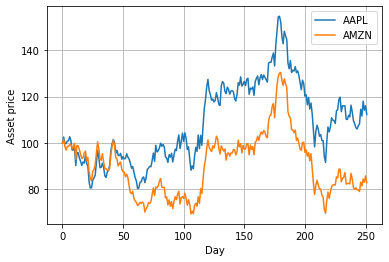

In [28]:
# Plot simulated price paths
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
array_day_plot = [t for t in range(T)]

for n in range(NUMBER_OF_STOCKS):
    ax.plot(array_day_plot, stock_price_array[n],\
                        label = '{}'.format(STOCK_TICKERS[n]))

plt.grid()
plt.xlabel('Day')
plt.ylabel('Asset price')
plt.legend(loc='best')

plt.show()

In [29]:
weights = {} 
for stock in STOCK_TICKERS:
  weights[stock] = 1 / NUMBER_OF_STOCKS

index = []
for t in range(T):
  index.append(0)
  for i, stock in enumerate(STOCK_TICKERS):
    index[t] += weights[stock] * stock_price_array[i][t]


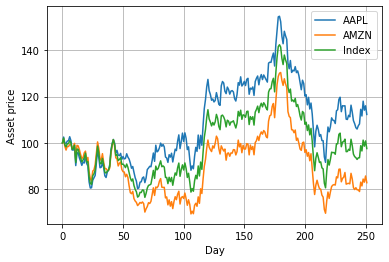

In [30]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
array_day_plot = [t for t in range(T)]

for n in range(NUMBER_OF_STOCKS):
    ax.plot(array_day_plot, stock_price_array[n],\
                        label = '{}'.format(STOCK_TICKERS[n]))
    
ax.plot(array_day_plot, index, label = 'Index')
plt.grid()
plt.xlabel('Day')
plt.ylabel('Asset price')
plt.legend(loc='best')

plt.show()

In [48]:
df = pd.DataFrame(stock_price_array)
df = df.transpose()
df = df.rename(columns={0: "AAPL", 1: "AMZN"})
df["Index"] = index
cols = ["AAPL", "AMZN", "Index"]
for col in cols:
  df[col + '_returns'] = df[col].pct_change(1)

# Check realised vol
# for col in cols:
#   print(df[col + '_returns'].dropna().std() * np.sqrt(T))

df['Prtf_val_s'] = 0.0
df['Prtf_val_e'] = 0.0

for stock in STOCK_TICKERS:
  df[stock + '_wt_s'] = 0.0
  df[stock + '_val_s'] = 0.0
  df[stock + '_nos_s'] = 0.0
  df[stock + '_wt_e'] = 0.0
  df[stock + '_val_e'] = 0.0
  df[stock + '_nos_e'] = 0.0
  df.at[0, stock + '_wt_s'] =  stock_data[stock]['Weight']
  df.at[0, stock + '_val_s'] =  df[stock].iloc[0] * stock_data[stock]['Weight']
  df.at[0, stock + '_nos_s'] = df[stock + '_val_s'].iloc[0] / df[stock].iloc[0]
  df.at[0, 'Prtf_val_s'] +=  df[stock + '_val_s'].iloc[0]

for t in range(1, T):
  rebalance = False
  for stock in STOCK_TICKERS:
    if abs(df[stock + '_val_s'].iloc[t-1]) > stock_data[stock]['Vol'] / sqrt(252):
      rebalance = True
  for stock in STOCK_TICKERS:
    if rebalance:
      df.at[t, stock + '_val_s'] = df['Prtf_val_s'].iloc[t-1] * stock_data[stock]['Weight']
      df.at[t, stock + '_nos_s'] = df[stock + '_val_s'].iloc[t] / df[stock].iloc[t]
    else: 
      df.at[t, stock + '_nos_s'] = df[stock + '_nos_s'].iloc[t-1]
      df.at[t, stock + '_val_s'] = df[stock].iloc[t] * df[stock + '_nos_s'].iloc[t-1]
    df.at[t, 'Prtf_val_s'] += df[stock + '_val_s'].iloc[t]
  for stock in STOCK_TICKERS:
    df.at[t, stock + '_wt_s'] = df[stock + '_val_s'].iloc[t] / df['Prtf_val_s'].iloc[t]


df

,AAPL,AMZN,Index,AAPL_returns,AMZN_returns,Index_returns,Prtf_val_s,Prtf_val_e,AAPL_wt_s,AAPL_val_s,AAPL_nos_s,AAPL_wt_e,AAPL_val_e,AAPL_nos_e,AMZN_wt_s,AMZN_val_s,AMZN_nos_s,AMZN_wt_e,AMZN_val_e,AMZN_nos_e
0,100.000000,100.000000,100.000000,NaN,NaN,NaN,100.0,0.0,0.5,50.0,0.500000,0.0,0.0,0.0,0.5,50.0,0.500000,0.0,0.0,0.0
1,102.568949,101.676486,102.122718,0.025689,0.016765,0.021227,100.0,0.0,0.5,50.0,0.487477,0.0,0.0,0.0,0.5,50.0,0.491756,0.0,0.0,0.0
2,99.832762,98.584546,99.208654,-0.026677,-0.030410,-0.028535,100.0,0.0,0.5,50.0,0.500838,0.0,0.0,0.0,0.5,50.0,0.507179,0.0,0.0,0.0
3,99.725243,96.966246,98.345745,-0.001077,-0.016415,-0.008698,100.0,0.0,0.5,50.0,0.501378,0.0,0.0,0.0,0.5,50.0,0.515643,0.0,0.0,0.0
4,100.851526,98.542665,99.697095,0.011294,0.016257,0.013741,100.0,0.0,0.5,50.0,0.495778,0.0,0.0,0.0,0.5,50.0,0.507394,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,111.628553,81.525918,96.577236,-0.025213,-0.019906,-0.022980,100.0,0.0,0.5,50.0,0.447914,0.0,0.0,0.0,0.5,50.0,0.613302,0.0,0.0,0.0
248,118.005378,84.490540,101.247959,0.057125,0.036364,0.048363,100.0,0.0,0.5,50.0,0.423710,0.0,0.0,0.0,0.5,50.0,0.591782,0.0,0.0,0.0
249,114.135848,83.145010,98.640429,-0.032791,-0.015925,-0.025754,100.0,0.0,0.5,50.0,0.438074,0.0,0.0,0.0,0.5,50.0,0.601359,0.0,0.0,0.0
250,116.017593,85.808854,100.913224,0.016487,0.032039,0.023041,100.0,0.0,0.5,50.0,0.430969,0.0,0.0,0.0,0.5,50.0,0.582690,0.0,0.0,0.0


In [32]:
for stock in STOCK_TICKERS:
  print(weights[stock])

0.5
0.5


In [42]:
stock_data['AAPL']['Vol'] / sqrt(252)

0.02519763153394848

In [33]:
data = {'toto':[1,2], 'tata':[3,4]}
dft = pd.DataFrame(data)
for i in range(len(dft)):
  print(dft['tata'].iloc[i])

3
4
